### Preparación del Ambiente

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

### Carga de la Data

In [2]:
data_path1 = '/content/drive/MyDrive/trainRNN.csv'
dataset = pd.read_csv(data_path1 , parse_dates=['date'])

### Autocorrelación de los Datos


La autocorrelación es considerablemente alta, por lo que un determinado valor depende de datos anteriores y por lo tanto se puede hacer una predicción.

In [3]:
#autocorrelación
dataset['sales'].autocorr(lag=1)

0.8784369673919291

### Gráfica AutoCorrelation Function

In [4]:
#fig = plot_acf(dataset['sales'], lags=20, alpha=0.05)
#fig.show()

### Gráfico de Descomposición

In [5]:
#seleccionar solo la columan date y high
datos_sales = dataset[['date','sales']]
#fijar la fecha como indice del data.frame
datos_ts =  datos_sales.set_index('date')
#organizar a partir del indice
datos_ts.sort_index(inplace=True)
#ver el conjunto de datos
#datos_ts.head()

#### Gráfica completa de las ventas

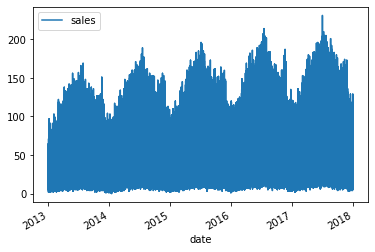

In [6]:
datos_ts.plot()

#### Se utilizará método aditivo ya que al contener un 0 el modelo multiplicativo da error.

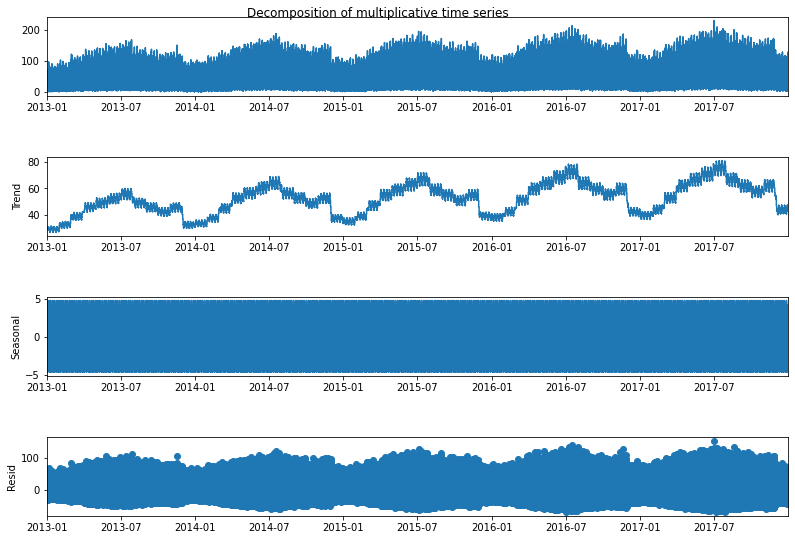

In [7]:
decomposition = sm.tsa.seasonal_decompose(datos_ts, model='additive', period = int(len(datos_ts)/400))

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
fig.show()

#### Para visualizar mejor los resultados se hace un promedio por mes

In [8]:
datos_ts_m = datos_ts.resample('M').mean()
datos_ts_m.head()

,sales
date,
2013-01-31,29.348645
2013-02-28,32.815500
2013-03-31,39.831097
2013-04-30,45.484933
2013-05-31,49.241419


#### Con el promedio se puede usar el modelo multiplicativo pues ya no hay valores 0 ni negativos. Se observa el comportamiento ciclico de la data así como la temporalidad que tiene a mediados de año.

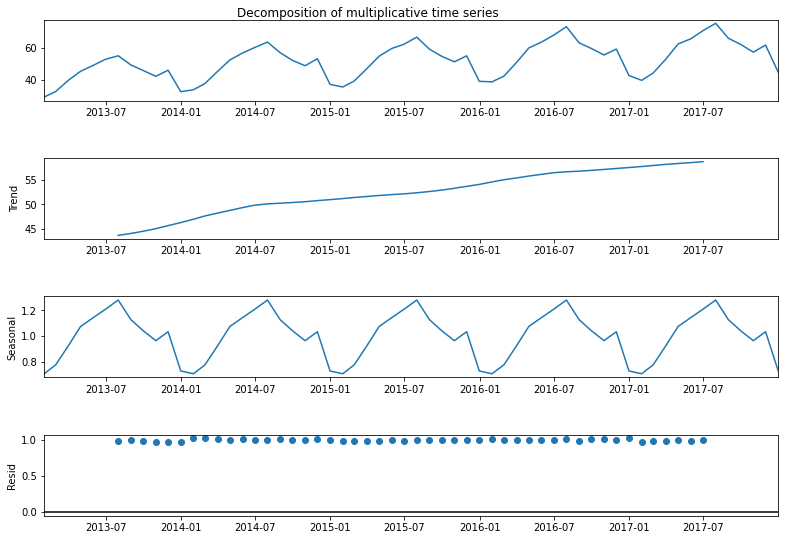

In [9]:
decomposition = sm.tsa.seasonal_decompose(datos_ts_m, model='multiplicative')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
fig.show()

### Data de Entrenamiento (80% del total de la data)

In [10]:
data_path1 = '/content/drive/MyDrive/trainRNN.csv'
dataset = pd.read_csv(data_path1 )

In [11]:
datatrain = dataset[dataset['date'].str.contains('2013|2014|2015|2016', regex=True)]
datatrain

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912630,2016-12-27,10,50,60
912631,2016-12-28,10,50,43
912632,2016-12-29,10,50,68
912633,2016-12-30,10,50,63


### Data de Validación (20% del total de la data)

In [12]:
datatest = dataset[dataset['date'].str.contains('2017')]
datatest

,date,store,item,sales
1461,2017-01-01,1,1,19
1462,2017-01-02,1,1,15
1463,2017-01-03,1,1,10
1464,2017-01-04,1,1,16
1465,2017-01-05,1,1,14
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


#### Procesamiento de la data: Se hace un pivote de los 50 items de cada una de las 10 tiendas.

#### Tienda 1

In [13]:
datatrain1 = datatrain.query('store == 1')
datatrain1 = datatrain1.pivot(index = 'date', columns = 'item', values = 'sales')
datatrain1['Total_Sales'] = datatrain1.sum(axis = 1)
datatrain1 = datatrain1.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatrain1 = datatrain1.iloc[:, 0:1].values

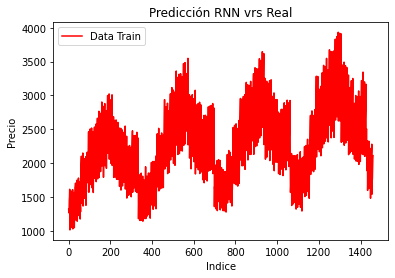

In [14]:
plt.plot(datatrain1, color='red', label='Data Train')
plt.title('Predicción RNN vrs Real')
plt.xlabel("Indice")
plt.ylabel("Precio")
plt.legend()
plt.show()

In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
datatrain1_scaled = scaler.fit_transform(datatrain1)

In [16]:
X_train = []
Y_train = []

#secuenciamos los datos.
cantidad = datatrain1_scaled.shape[0]
ventana = 60
for i in range(ventana, cantidad):
  X_train.append(datatrain1_scaled[i - ventana: i, 0])
  Y_train.append(datatrain1_scaled[i, 0])

In [17]:
X_train = np.array(X_train)
y_train = np.array(Y_train)

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #reshape para entrada en Keras.

In [19]:
forecaster = Sequential()
#capa1
forecaster.add(LSTM(input_shape=(X_train.shape[1], 1), units=50, return_sequences=True))
#capa2
forecaster.add(LSTM(units=50, return_sequences=True))
#capa3
forecaster.add(LSTM(units=25, return_sequences=True))
#capa4 - NOTAAAAR :) que la capa previa a la salida, no requiere feedback ya que es el resultado final.
forecaster.add(LSTM(units=75, return_sequences=False))
#capa de salida
forecaster.add(Dense(units=1, activation='relu'))

In [20]:
#parametros de optimización
forecaster.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
#parametros de entrenamiento
forecaster.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
44/44 [==============================] - 12s 115ms/step - loss: 0.0339
Epoch 2/100
44/44 [==============================] - 5s 116ms/step - loss: 0.0157
Epoch 3/100
44/44 [==============================] - 5s 115ms/step - loss: 0.0148
Epoch 4/100
44/44 [==============================] - 5s 116ms/step - loss: 0.0143
Epoch 5/100
44/44 [==============================] - 5s 115ms/step - loss: 0.0138
Epoch 6/100
44/44 [==============================] - 5s 115ms/step - loss: 0.0137
Epoch 7/100
44/44 [==============================] - 5s 115ms/step - loss: 0.0142
Epoch 8/100
44/44 [==============================] - 5s 117ms/step - loss: 0.0144
Epoch 9/100
44/44 [==============================] - 5s 114ms/step - loss: 0.0135
Epoch 10/100
44/44 [==============================] - 5s 116ms/step - loss: 0.0135
Epoch 11/100
44/44 [==============================] - 5s 115ms/step - loss: 0.0135
Epoch 12/100
44/44 [==============================] - 5s 116ms/step - loss: 0.0139
Epoch 13/100

In [22]:
#forecaster.save('/content/drive/MyDrive/RNN_v1.h5')

In [23]:
datatest1 = datatest.query('store == 1')
datatest1 = datatest1.pivot(index = 'date', columns = 'item', values = 'sales')
datatest1['Total_Sales'] = datatest1.sum(axis = 1)
datatest1 = datatest1.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatest1 = datatest1.iloc[:, 0:1].values

In [24]:
real_test_price = datatest1

In [25]:
dataset_total = pd.concat((pd.Series(datatrain1[:,0]), pd.Series(datatest1[:,0])), axis=0)
#dataset_total

In [26]:
input_test = dataset_total[len(dataset_total) - len(datatest1) - ventana : ].values
input_test = input_test.reshape(-1, 1)
input_test = scaler.transform(input_test)
#input_test

In [27]:
cantidad_final = len(input_test)
cantidad_final

425

In [28]:
X_test = []
for i in range(ventana, cantidad_final):
  X_test.append(input_test[i - ventana:i, 0])

X_test = np.array(X_test)

In [29]:
X_test.shape

(365, 60)

In [30]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [31]:
X_test.shape

(365, 60, 1)

In [32]:
predicciones_rnn = forecaster.predict(X_test)
#predicciones_rnn

In [33]:
real_predicted_price = scaler.inverse_transform(predicciones_rnn)
#real_predicted_price

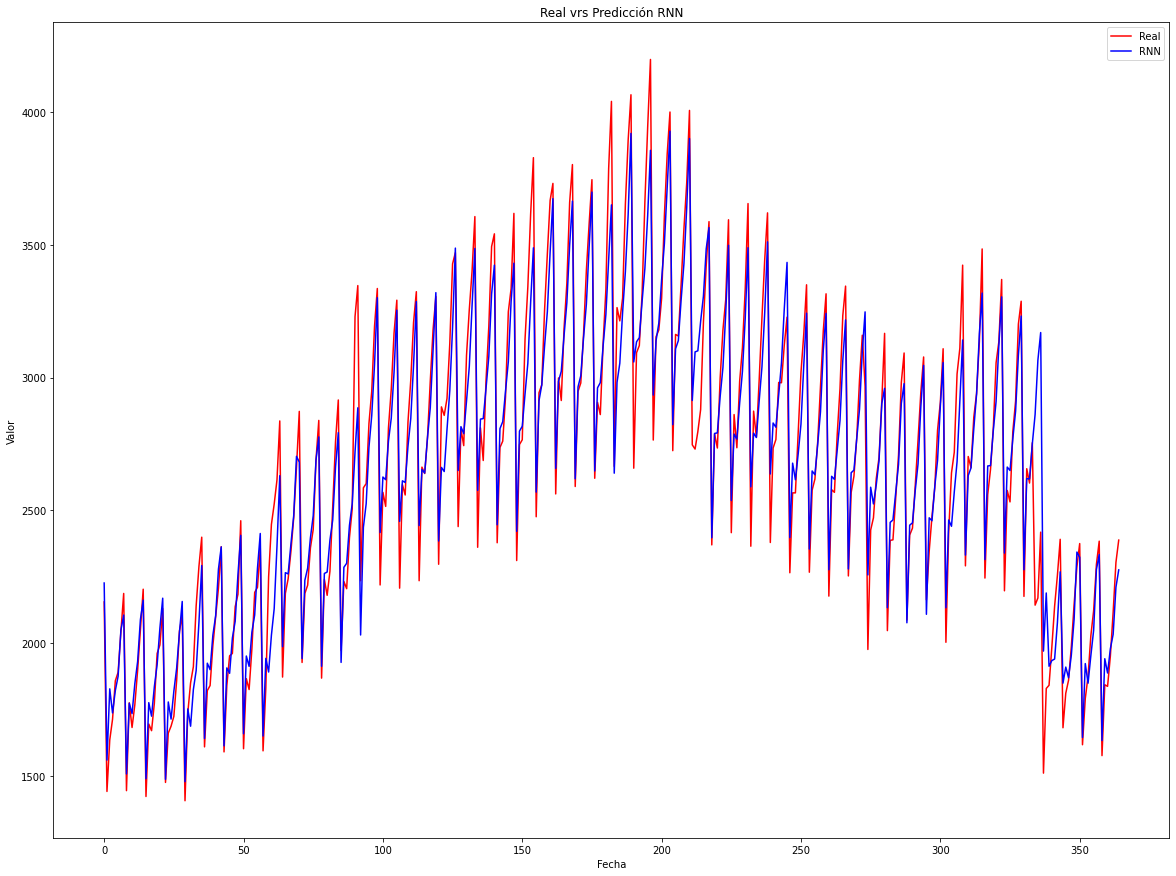

In [34]:
plt.figure(figsize=(20, 15))
plt.plot(real_test_price, color="red", label="Real")
plt.plot(real_predicted_price, color="blue", label="RNN")
plt.title("Real vrs Predicción RNN")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()

### Calculo SMAPE Tienda 1

In [35]:
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

In [36]:
smape(real_test_price, real_predicted_price)

4.0256851666585565

### Tienda 2

In [37]:
datatrain2 = datatrain.query('store == 2')
datatrain2 = datatrain2.pivot(index = 'date', columns = 'item', values = 'sales')
datatrain2['Total_Sales'] = datatrain2.sum(axis = 1)
datatrain2 = datatrain2.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatrain2 = datatrain2.iloc[:, 0:1].values

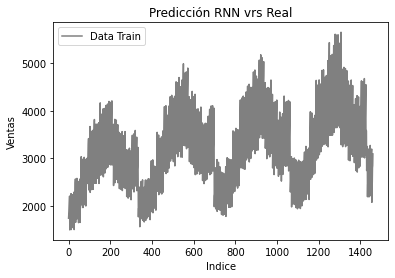

In [38]:
plt.plot(datatrain2, color='gray', label='Data Train')
plt.title('Predicción RNN vrs Real')
plt.xlabel("Indice")
plt.ylabel("Ventas")
plt.legend()
plt.show()

In [39]:
#from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
datatrain2_scaled = scaler.fit_transform(datatrain2)

In [40]:
X_train = []
Y_train = []

#secuenciamos los datos.
cantidad = datatrain2_scaled.shape[0]
ventana = 30
for i in range(ventana, cantidad):
  X_train.append(datatrain2_scaled[i - ventana: i, 0])
  Y_train.append(datatrain2_scaled[i, 0])

In [41]:
X_train = np.array(X_train)
y_train = np.array(Y_train)

In [42]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #reshape para entrada en Keras.

In [43]:
forecaster = Sequential()
#capa1
forecaster.add(LSTM(input_shape=(X_train.shape[1], 1), units=50, return_sequences=True))
#capa2
forecaster.add(LSTM(units=50, return_sequences=True))
#capa3
forecaster.add(LSTM(units=25, return_sequences=True))
#capa4 - NOTAAAAR :) que la capa previa a la salida, no requiere feedback ya que es el resultado final.
forecaster.add(LSTM(units=75, return_sequences=False))
#capa de salida
forecaster.add(Dense(units=1, activation='relu'))

In [44]:
#parametros de optimización
forecaster.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
#parametros de entrenamiento
forecaster.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
45/45 [==============================] - 10s 63ms/step - loss: 0.0333
Epoch 2/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0147
Epoch 3/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0150
Epoch 4/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0144
Epoch 5/100
45/45 [==============================] - 3s 61ms/step - loss: 0.0143
Epoch 6/100
45/45 [==============================] - 3s 61ms/step - loss: 0.0141
Epoch 7/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0134
Epoch 8/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0135
Epoch 9/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0135
Epoch 10/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0131
Epoch 11/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0137
Epoch 12/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0129
Epoch 13/100
45/45 [====

In [46]:
#forecaster.save('/content/drive/MyDrive/RNN_v1.h5')

In [47]:
datatest2 = datatest.query('store == 2')
datatest2 = datatest2.pivot(index = 'date', columns = 'item', values = 'sales')
datatest2['Total_Sales'] = datatest2.sum(axis = 1)
datatest2 = datatest2.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatest2 = datatest2.iloc[:, 0:1].values

In [48]:
real_test_price = datatest2

In [49]:
dataset_total = pd.concat((pd.Series(datatrain2[:,0]), pd.Series(datatest2[:,0])), axis=0)
#dataset_total

In [50]:
input_test = dataset_total[len(dataset_total) - len(datatest2) - ventana : ].values
input_test = input_test.reshape(-1, 1)
input_test = scaler.transform(input_test)
#input_test

In [51]:
cantidad_final = len(input_test)
cantidad_final

395

In [52]:
X_test = []
for i in range(ventana, cantidad_final):
  X_test.append(input_test[i - ventana:i, 0])

X_test = np.array(X_test)

In [53]:
X_test.shape

(365, 30)

In [54]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [55]:
X_test.shape

(365, 30, 1)

In [56]:
predicciones_rnn = forecaster.predict(X_test)
#predicciones_rnn

In [57]:
real_predicted_price = scaler.inverse_transform(predicciones_rnn)
#real_predicted_price

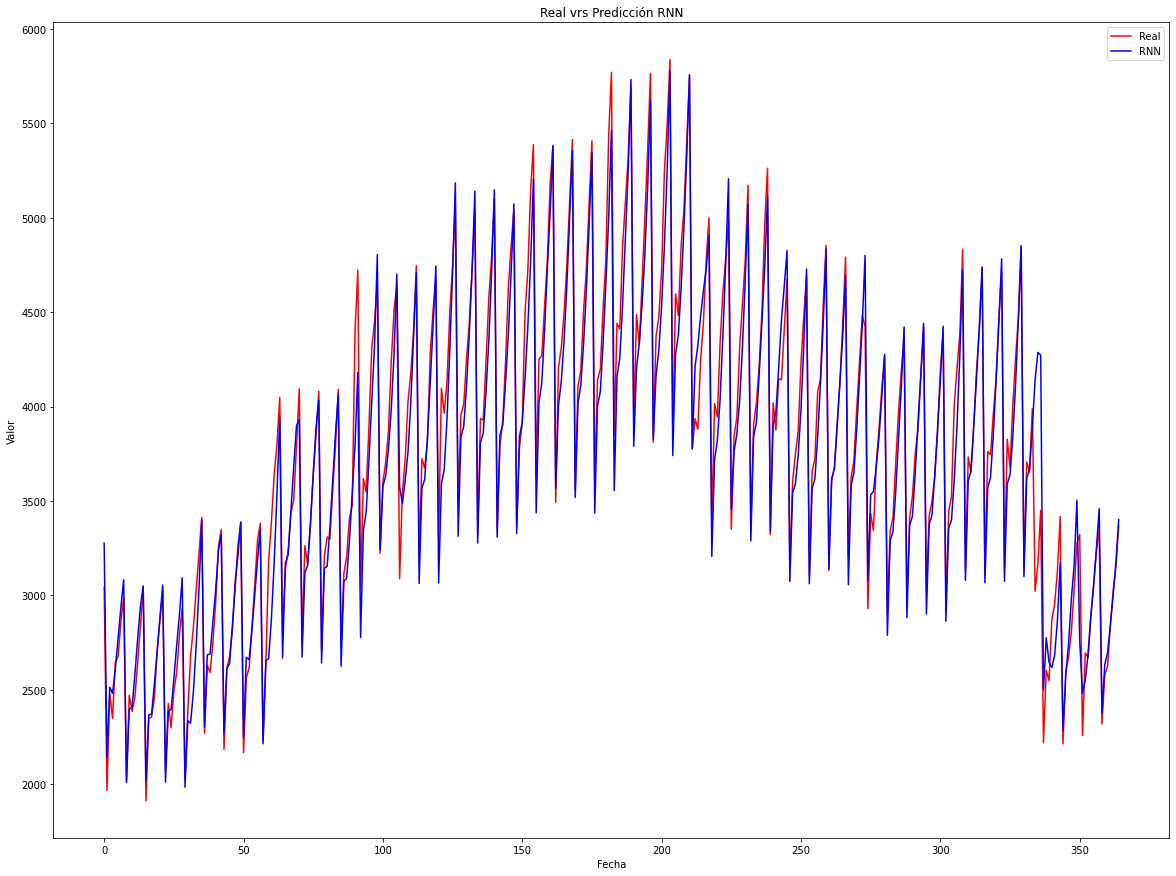

In [58]:
plt.figure(figsize=(20, 15))
plt.plot(real_test_price, color="red", label="Real")
plt.plot(real_predicted_price, color="blue", label="RNN")
plt.title("Real vrs Predicción RNN")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()

### Calculo SMAPE Tienda 2

In [59]:
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

In [60]:
smape(real_test_price, real_predicted_price)

3.4762758158639104

### Tienda 3

In [83]:
datatrain3 = datatrain.query('store == 3')
datatrain3 = datatrain3.pivot(index = 'date', columns = 'item', values = 'sales')
datatrain3['Total_Sales'] = datatrain3.sum(axis = 1)
datatrain3 = datatrain3.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatrain3 = datatrain3.iloc[:, 0:1].values

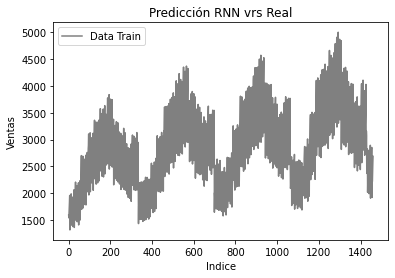

In [84]:
plt.plot(datatrain3, color='gray', label='Data Train')
plt.title('Predicción RNN vrs Real')
plt.xlabel("Indice")
plt.ylabel("Ventas")
plt.legend()
plt.show()

In [85]:
#from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
datatrain3_scaled = scaler.fit_transform(datatrain3)

In [86]:
X_train = []
Y_train = []

#secuenciamos los datos.
cantidad = datatrain3_scaled.shape[0]
ventana = 60
for i in range(ventana, cantidad):
  X_train.append(datatrain3_scaled[i - ventana: i, 0])
  Y_train.append(datatrain3_scaled[i, 0])

In [87]:
X_train = np.array(X_train)
y_train = np.array(Y_train)

In [88]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #reshape para entrada en Keras.

In [89]:
forecaster = Sequential()
#capa1
forecaster.add(LSTM(input_shape=(X_train.shape[1], 1), units=50, return_sequences=True))
#capa2
forecaster.add(LSTM(units=50, return_sequences=True))
#capa3
forecaster.add(LSTM(units=25, return_sequences=True))
#capa4 - NOTAAAAR :) que la capa previa a la salida, no requiere feedback ya que es el resultado final.
forecaster.add(LSTM(units=75, return_sequences=False))
#capa de salida
forecaster.add(Dense(units=1, activation='relu'))

In [90]:
#parametros de optimización
forecaster.compile(optimizer='adam', loss='mean_squared_error')

In [91]:
#parametros de entrenamiento
forecaster.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
44/44 [==============================] - 12s 116ms/step - loss: 0.0353
Epoch 2/100
44/44 [==============================] - 5s 116ms/step - loss: 0.0149
Epoch 3/100
44/44 [==============================] - 5s 115ms/step - loss: 0.0142
Epoch 4/100
44/44 [==============================] - 5s 115ms/step - loss: 0.0150
Epoch 5/100
44/44 [==============================] - 5s 118ms/step - loss: 0.0143
Epoch 6/100
44/44 [==============================] - 5s 116ms/step - loss: 0.0140
Epoch 7/100
44/44 [==============================] - 5s 116ms/step - loss: 0.0141
Epoch 8/100
44/44 [==============================] - 5s 116ms/step - loss: 0.0136
Epoch 9/100
44/44 [==============================] - 5s 115ms/step - loss: 0.0131
Epoch 10/100
44/44 [==============================] - 5s 116ms/step - loss: 0.0128
Epoch 11/100
44/44 [==============================] - 5s 117ms/step - loss: 0.0131
Epoch 12/100
44/44 [==============================] - 5s 117ms/step - loss: 0.0128
Epoch 13/100

In [92]:
#forecaster.save('/content/drive/MyDrive/RNN_v1.h5')

In [93]:
datatest3 = datatest.query('store == 3')
datatest3 = datatest3.pivot(index = 'date', columns = 'item', values = 'sales')
datatest3['Total_Sales'] = datatest3.sum(axis = 1)
datatest3 = datatest3.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatest3 = datatest3.iloc[:, 0:1].values

In [94]:
real_test_price = datatest3

In [95]:
dataset_total = pd.concat((pd.Series(datatrain3[:,0]), pd.Series(datatest3[:,0])), axis=0)
#dataset_total

In [96]:
input_test = dataset_total[len(dataset_total) - len(datatest3) - ventana : ].values
input_test = input_test.reshape(-1, 1)
input_test = scaler.transform(input_test)
#input_test

In [97]:
cantidad_final = len(input_test)
cantidad_final

425

In [98]:
X_test = []
for i in range(ventana, cantidad_final):
  X_test.append(input_test[i - ventana:i, 0])

X_test = np.array(X_test)

In [99]:
X_test.shape

(365, 60)

In [100]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [101]:
X_test.shape

(365, 60, 1)

In [102]:
predicciones_rnn = forecaster.predict(X_test)
#predicciones_rnn

In [103]:
real_predicted_price = scaler.inverse_transform(predicciones_rnn)
#real_predicted_price

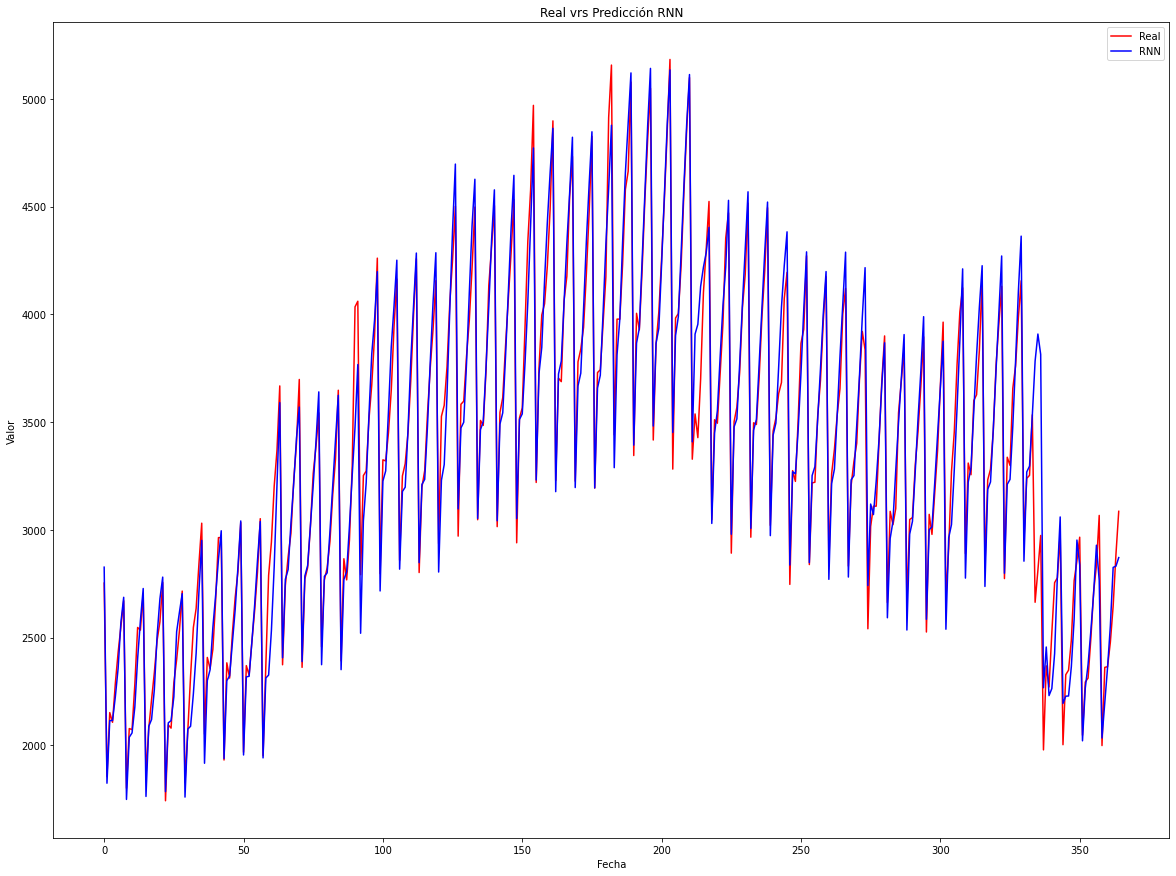

In [104]:
plt.figure(figsize=(20, 15))
plt.plot(real_test_price, color="red", label="Real")
plt.plot(real_predicted_price, color="blue", label="RNN")
plt.title("Real vrs Predicción RNN")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()

### Calculo SMAPE Tienda 3

In [105]:
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

In [106]:
smape(real_test_price, real_predicted_price)

2.9183769940579447

### Tienda 4

In [107]:
datatrain4 = datatrain.query('store == 4')
datatrain4 = datatrain4.pivot(index = 'date', columns = 'item', values = 'sales')
datatrain4['Total_Sales'] = datatrain4.sum(axis = 1)
datatrain4 = datatrain4.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatrain4 = datatrain4.iloc[:, 0:1].values

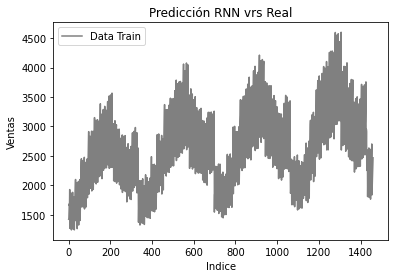

In [108]:
plt.plot(datatrain4, color='gray', label='Data Train')
plt.title('Predicción RNN vrs Real')
plt.xlabel("Indice")
plt.ylabel("Ventas")
plt.legend()
plt.show()

In [109]:
#from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
datatrain4_scaled = scaler.fit_transform(datatrain4)

In [110]:
X_train = []
Y_train = []

#secuenciamos los datos.
cantidad = datatrain4_scaled.shape[0]
ventana = 30
for i in range(ventana, cantidad):
  X_train.append(datatrain4_scaled[i - ventana: i, 0])
  Y_train.append(datatrain4_scaled[i, 0])

In [111]:
X_train = np.array(X_train)
y_train = np.array(Y_train)

In [112]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #reshape para entrada en Keras.

In [113]:
forecaster = Sequential()
#capa1
forecaster.add(LSTM(input_shape=(X_train.shape[1], 1), units=50, return_sequences=True))
#capa2
forecaster.add(LSTM(units=50, return_sequences=True))
#capa3
forecaster.add(LSTM(units=25, return_sequences=True))
#capa4 - NOTAAAAR :) que la capa previa a la salida, no requiere feedback ya que es el resultado final.
forecaster.add(LSTM(units=75, return_sequences=False))
#capa de salida
forecaster.add(Dense(units=1, activation='relu'))

In [114]:
#parametros de optimización
forecaster.compile(optimizer='adam', loss='mean_squared_error')

In [115]:
#parametros de entrenamiento
forecaster.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
45/45 [==============================] - 10s 62ms/step - loss: 0.0338
Epoch 2/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0149
Epoch 3/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0150
Epoch 4/100
45/45 [==============================] - 4s 90ms/step - loss: 0.0148
Epoch 5/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0143
Epoch 6/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0148
Epoch 7/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0138
Epoch 8/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0135
Epoch 9/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0138
Epoch 10/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0144
Epoch 11/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0147
Epoch 12/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0142
Epoch 13/100
45/45 [====

In [116]:
#forecaster.save('/content/drive/MyDrive/RNN_v1.h5')

In [117]:
datatest4 = datatest.query('store == 2')
datatest4 = datatest4.pivot(index = 'date', columns = 'item', values = 'sales')
datatest4['Total_Sales'] = datatest4.sum(axis = 1)
datatest4 = datatest4.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatest4 = datatest4.iloc[:, 0:1].values

In [118]:
real_test_price = datatest4

In [119]:
dataset_total = pd.concat((pd.Series(datatrain4[:,0]), pd.Series(datatest4[:,0])), axis=0)
#dataset_total

In [120]:
input_test = dataset_total[len(dataset_total) - len(datatest4) - ventana : ].values
input_test = input_test.reshape(-1, 1)
input_test = scaler.transform(input_test)
#input_test

In [121]:
cantidad_final = len(input_test)
cantidad_final

395

In [122]:
X_test = []
for i in range(ventana, cantidad_final):
  X_test.append(input_test[i - ventana:i, 0])

X_test = np.array(X_test)

In [123]:
X_test.shape

(365, 30)

In [124]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [125]:
X_test.shape

(365, 30, 1)

In [126]:
predicciones_rnn = forecaster.predict(X_test)
#predicciones_rnn

In [127]:
real_predicted_price = scaler.inverse_transform(predicciones_rnn)
#real_predicted_price

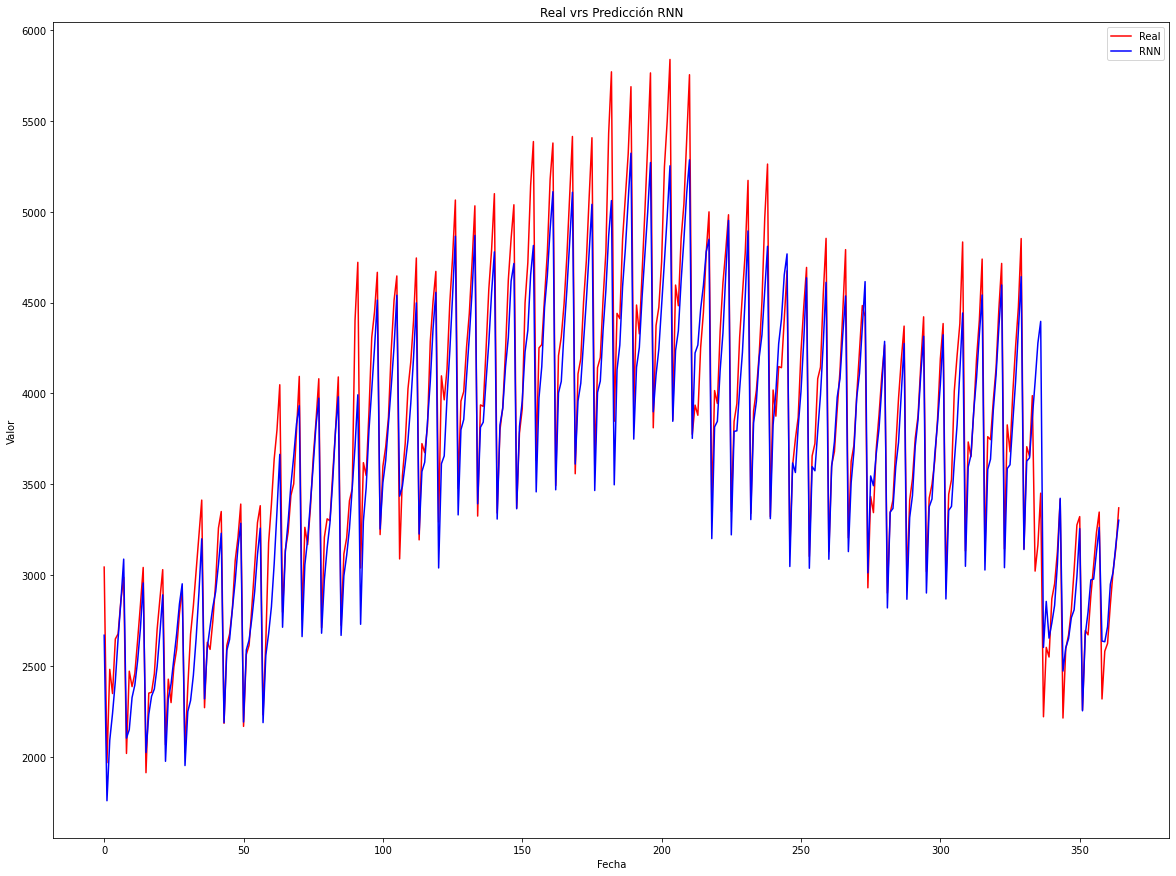

In [128]:
plt.figure(figsize=(20, 15))
plt.plot(real_test_price, color="red", label="Real")
plt.plot(real_predicted_price, color="blue", label="RNN")
plt.title("Real vrs Predicción RNN")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()

### Calculo SMAPE Tienda 4

In [129]:
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

In [130]:
smape(real_test_price, real_predicted_price)

4.446342324688099

### Calculo SMAPE Tienda 4

In [ ]:
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

In [ ]:
smape(real_test_price, real_predicted_price)

4.446342324688099

### Tienda 5

In [154]:
datatrain5 = datatrain.query('store == 5')
datatrain5 = datatrain5.pivot(index = 'date', columns = 'item', values = 'sales')
datatrain5['Total_Sales'] = datatrain5.sum(axis = 1)
datatrain5 = datatrain5.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatrain5 = datatrain5.iloc[:, 0:1].values

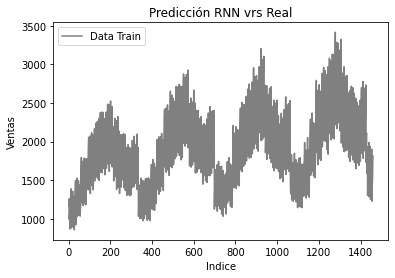

In [155]:
plt.plot(datatrain5, color='gray', label='Data Train')
plt.title('Predicción RNN vrs Real')
plt.xlabel("Indice")
plt.ylabel("Ventas")
plt.legend()
plt.show()

In [156]:
#from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
datatrain5_scaled = scaler.fit_transform(datatrain5)

In [157]:
X_train = []
Y_train = []

#secuenciamos los datos.
cantidad = datatrain5_scaled.shape[0]
ventana = 30
for i in range(ventana, cantidad):
  X_train.append(datatrain5_scaled[i - ventana: i, 0])
  Y_train.append(datatrain5_scaled[i, 0])

In [158]:
X_train = np.array(X_train)
y_train = np.array(Y_train)

In [159]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #reshape para entrada en Keras.

In [160]:
forecaster = Sequential()
#capa1
forecaster.add(LSTM(input_shape=(X_train.shape[1], 1), units=50, return_sequences=True))
#capa2
forecaster.add(LSTM(units=50, return_sequences=True))
#capa3
forecaster.add(LSTM(units=25, return_sequences=True))
#capa4 - NOTAAAAR :) que la capa previa a la salida, no requiere feedback ya que es el resultado final.
forecaster.add(LSTM(units=75, return_sequences=False))
#capa de salida
forecaster.add(Dense(units=1, activation='relu'))

In [161]:
#parametros de optimización
forecaster.compile(optimizer='adam', loss='mean_squared_error')

In [162]:
#parametros de entrenamiento
forecaster.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
45/45 [==============================] - 10s 62ms/step - loss: 0.0329
Epoch 2/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0141
Epoch 3/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0139
Epoch 4/100
45/45 [==============================] - 3s 61ms/step - loss: 0.0139
Epoch 5/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0130
Epoch 6/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0127
Epoch 7/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0130
Epoch 8/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0129
Epoch 9/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0127
Epoch 10/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0124
Epoch 11/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0126
Epoch 12/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0124
Epoch 13/100
45/45 [====

In [163]:
#forecaster.save('/content/drive/MyDrive/RNN_v1.h5')

In [164]:
datatest5 = datatest.query('store == 5')
datatest5 = datatest5.pivot(index = 'date', columns = 'item', values = 'sales')
datatest5['Total_Sales'] = datatest5.sum(axis = 1)
datatest5 = datatest5.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatest5 = datatest5.iloc[:, 0:1].values

In [165]:
real_test_price = datatest5

In [166]:
dataset_total = pd.concat((pd.Series(datatrain5[:,0]), pd.Series(datatest5[:,0])), axis=0)
#dataset_total

In [167]:
input_test = dataset_total[len(dataset_total) - len(datatest5) - ventana : ].values
input_test = input_test.reshape(-1, 1)
input_test = scaler.transform(input_test)
#input_test

In [168]:
cantidad_final = len(input_test)
cantidad_final

395

In [169]:
X_test = []
for i in range(ventana, cantidad_final):
  X_test.append(input_test[i - ventana:i, 0])

X_test = np.array(X_test)

In [170]:
X_test.shape

(365, 30)

In [171]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [172]:
X_test.shape

(365, 30, 1)

In [173]:
predicciones_rnn = forecaster.predict(X_test)
#predicciones_rnn

In [174]:
real_predicted_price = scaler.inverse_transform(predicciones_rnn)
#real_predicted_price

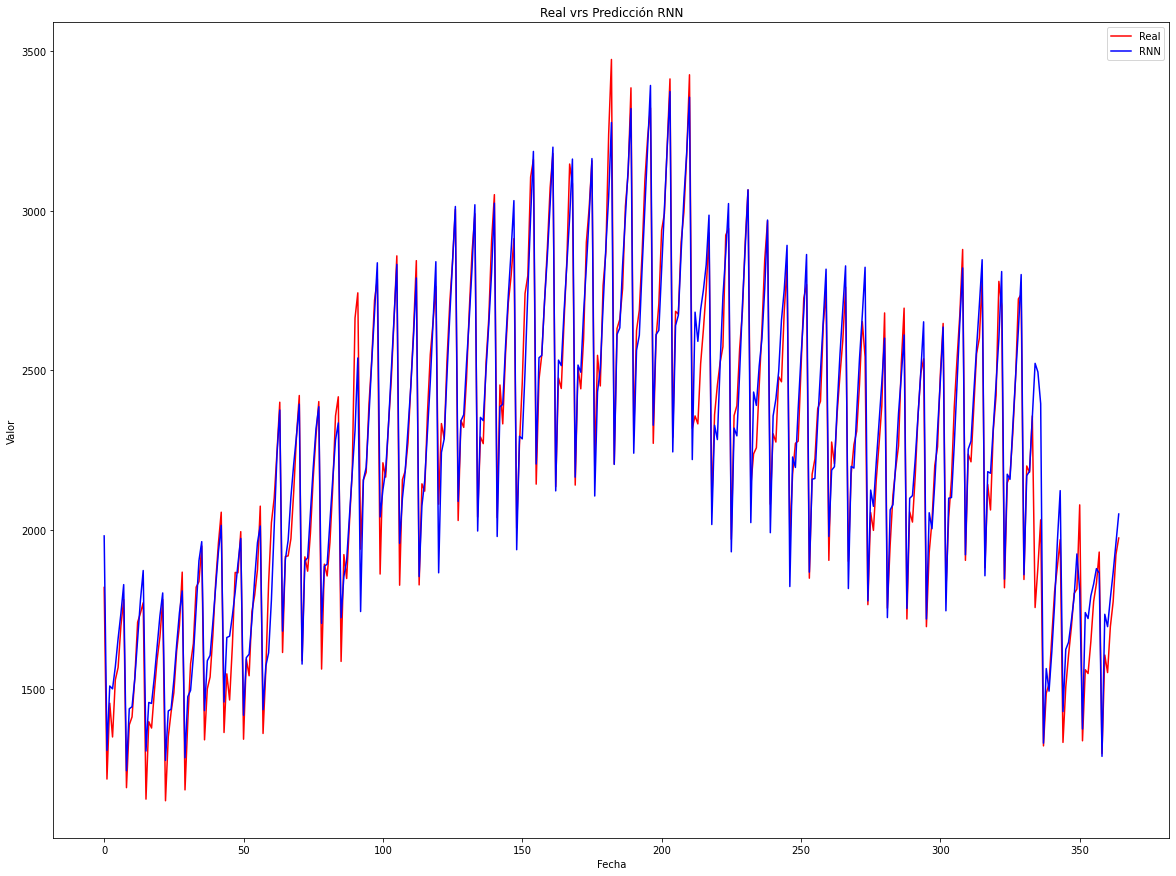

In [175]:
plt.figure(figsize=(20, 15))
plt.plot(real_test_price, color="red", label="Real")
plt.plot(real_predicted_price, color="blue", label="RNN")
plt.title("Real vrs Predicción RNN")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()

### Calculo SMAPE Tienda 5

In [176]:
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

In [177]:
smape(real_test_price, real_predicted_price)

3.2364333811957073

### Tienda 6

In [178]:
datatrain6 = datatrain.query('store == 6')
datatrain6 = datatrain6.pivot(index = 'date', columns = 'item', values = 'sales')
datatrain6['Total_Sales'] = datatrain6.sum(axis = 1)
datatrain6 = datatrain6.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatrain6 = datatrain6.iloc[:, 0:1].values

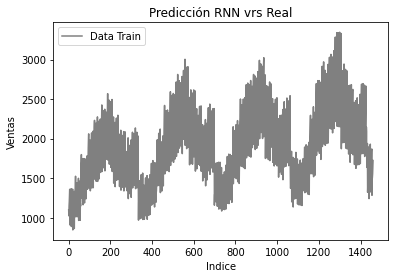

In [179]:
plt.plot(datatrain6, color='gray', label='Data Train')
plt.title('Predicción RNN vrs Real')
plt.xlabel("Indice")
plt.ylabel("Ventas")
plt.legend()
plt.show()

In [180]:
#from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
datatrain6_scaled = scaler.fit_transform(datatrain6)

In [181]:
X_train = []
Y_train = []

#secuenciamos los datos.
cantidad = datatrain6_scaled.shape[0]
ventana = 60
for i in range(ventana, cantidad):
  X_train.append(datatrain6_scaled[i - ventana: i, 0])
  Y_train.append(datatrain6_scaled[i, 0])

In [182]:
X_train = np.array(X_train)
y_train = np.array(Y_train)

In [183]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #reshape para entrada en Keras.

In [184]:
forecaster = Sequential()
#capa1
forecaster.add(LSTM(input_shape=(X_train.shape[1], 1), units=50, return_sequences=True))
#capa2
forecaster.add(LSTM(units=50, return_sequences=True))
#capa3
forecaster.add(LSTM(units=25, return_sequences=True))
#capa4 - NOTAAAAR :) que la capa previa a la salida, no requiere feedback ya que es el resultado final.
forecaster.add(LSTM(units=75, return_sequences=False))
#capa de salida
forecaster.add(Dense(units=1, activation='relu'))

In [185]:
#parametros de optimización
forecaster.compile(optimizer='adam', loss='mean_squared_error')

In [186]:
#parametros de entrenamiento
forecaster.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
44/44 [==============================] - 12s 116ms/step - loss: 0.0332
Epoch 2/100
44/44 [==============================] - 5s 115ms/step - loss: 0.0143
Epoch 3/100
44/44 [==============================] - 5s 115ms/step - loss: 0.0136
Epoch 4/100
44/44 [==============================] - 5s 114ms/step - loss: 0.0136
Epoch 5/100
44/44 [==============================] - 5s 117ms/step - loss: 0.0141
Epoch 6/100
44/44 [==============================] - 5s 115ms/step - loss: 0.0133
Epoch 7/100
44/44 [==============================] - 5s 116ms/step - loss: 0.0131
Epoch 8/100
44/44 [==============================] - 6s 129ms/step - loss: 0.0129
Epoch 9/100
44/44 [==============================] - 5s 116ms/step - loss: 0.0128
Epoch 10/100
44/44 [==============================] - 6s 147ms/step - loss: 0.0126
Epoch 11/100
44/44 [==============================] - 6s 131ms/step - loss: 0.0129
Epoch 12/100
44/44 [==============================] - 5s 116ms/step - loss: 0.0127
Epoch 13/100

In [187]:
#forecaster.save('/content/drive/MyDrive/RNN_v1.h5')

In [188]:
datatest6 = datatest.query('store == 6')
datatest6 = datatest6.pivot(index = 'date', columns = 'item', values = 'sales')
datatest6['Total_Sales'] = datatest6.sum(axis = 1)
datatest6 = datatest6.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatest6 = datatest6.iloc[:, 0:1].values

In [189]:
real_test_price = datatest6

In [190]:
dataset_total = pd.concat((pd.Series(datatrain6[:,0]), pd.Series(datatest6[:,0])), axis=0)
#dataset_total

In [191]:
input_test = dataset_total[len(dataset_total) - len(datatest6) - ventana : ].values
input_test = input_test.reshape(-1, 1)
input_test = scaler.transform(input_test)
#input_test

In [192]:
cantidad_final = len(input_test)
cantidad_final

425

In [193]:
X_test = []
for i in range(ventana, cantidad_final):
  X_test.append(input_test[i - ventana:i, 0])

X_test = np.array(X_test)

In [194]:
X_test.shape

(365, 60)

In [195]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [196]:
X_test.shape

(365, 60, 1)

In [197]:
predicciones_rnn = forecaster.predict(X_test)
#predicciones_rnn

In [198]:
real_predicted_price = scaler.inverse_transform(predicciones_rnn)
#real_predicted_price

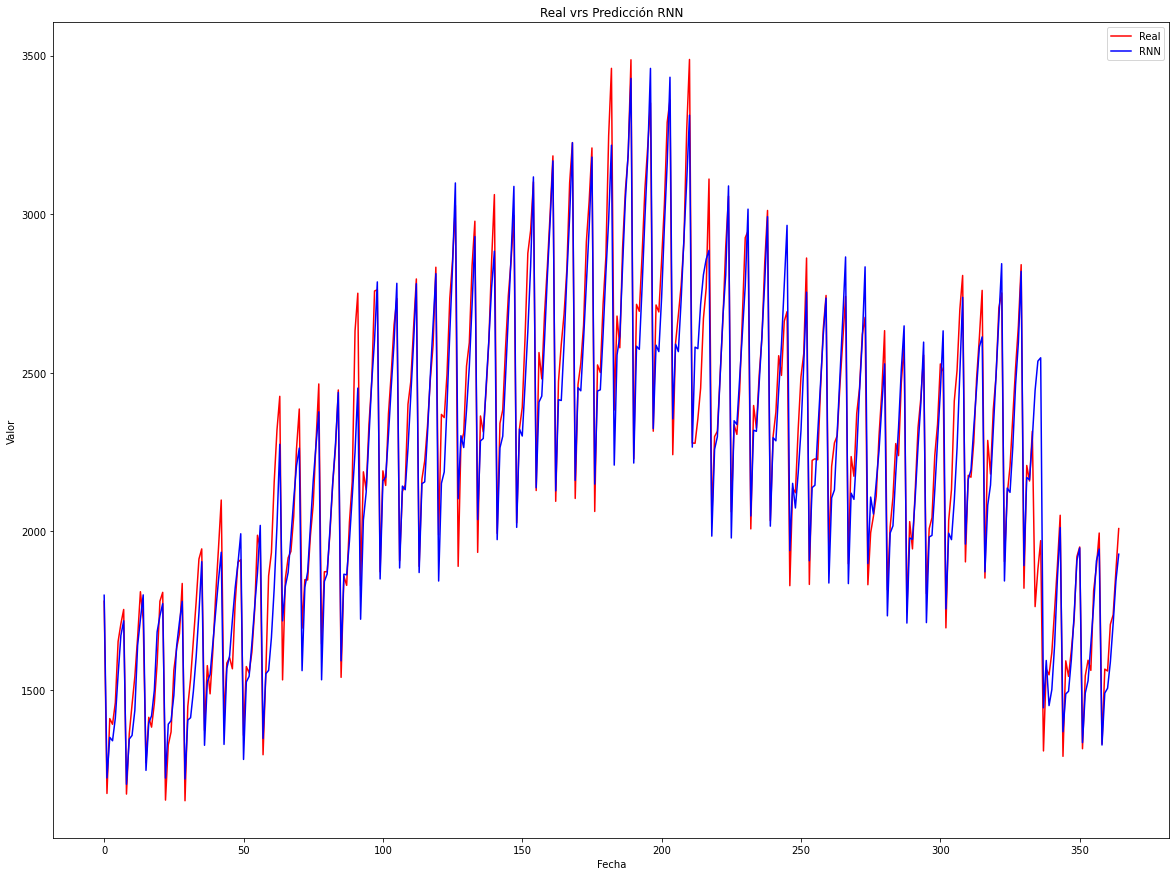

In [199]:
plt.figure(figsize=(20, 15))
plt.plot(real_test_price, color="red", label="Real")
plt.plot(real_predicted_price, color="blue", label="RNN")
plt.title("Real vrs Predicción RNN")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()

### Calculo SMAPE Tienda 6

In [200]:
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

In [201]:
smape(real_test_price, real_predicted_price)

3.5976785769342747

### Tienda 7

In [246]:
datatrain7 = datatrain.query('store == 7')
datatrain7 = datatrain7.pivot(index = 'date', columns = 'item', values = 'sales')
datatrain7['Total_Sales'] = datatrain7.sum(axis = 1)
datatrain7 = datatrain7.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatrain7 = datatrain7.iloc[:, 0:1].values

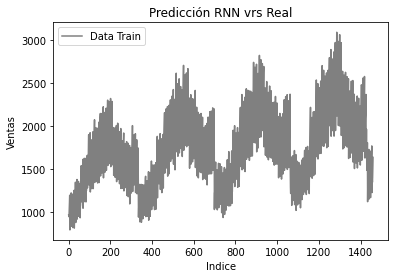

In [247]:
plt.plot(datatrain7, color='gray', label='Data Train')
plt.title('Predicción RNN vrs Real')
plt.xlabel("Indice")
plt.ylabel("Ventas")
plt.legend()
plt.show()

In [248]:
#from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
datatrain7_scaled = scaler.fit_transform(datatrain7)

In [249]:
X_train = []
Y_train = []

#secuenciamos los datos.
cantidad = datatrain7_scaled.shape[0]
ventana = 20
for i in range(ventana, cantidad):
  X_train.append(datatrain7_scaled[i - ventana: i, 0])
  Y_train.append(datatrain7_scaled[i, 0])

In [250]:
X_train = np.array(X_train)
y_train = np.array(Y_train)

In [251]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #reshape para entrada en Keras.

In [252]:
forecaster = Sequential()
#capa1
forecaster.add(LSTM(input_shape=(X_train.shape[1], 1), units=50, return_sequences=True))
#capa2
forecaster.add(LSTM(units=50, return_sequences=True))
#capa3
forecaster.add(LSTM(units=25, return_sequences=True))
#capa4 - NOTAAAAR :) que la capa previa a la salida, no requiere feedback ya que es el resultado final.
forecaster.add(LSTM(units=75, return_sequences=False))
#capa de salida
forecaster.add(Dense(units=1, activation='relu'))

In [253]:
#parametros de optimización
forecaster.compile(optimizer='adam', loss='mean_squared_error')

In [254]:
#parametros de entrenamiento
forecaster.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
46/46 [==============================] - 9s 41ms/step - loss: 0.0376
Epoch 2/100
46/46 [==============================] - 2s 41ms/step - loss: 0.0148
Epoch 3/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0137
Epoch 4/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 5/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0163
Epoch 6/100
46/46 [==============================] - 2s 41ms/step - loss: 0.0138
Epoch 7/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0128
Epoch 8/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0135
Epoch 9/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0123
Epoch 10/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0128
Epoch 11/100
46/46 [==============================] - 2s 41ms/step - loss: 0.0121
Epoch 12/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0126
Epoch 13/100
46/46 [=====

In [255]:
#forecaster.save('/content/drive/MyDrive/RNN_v1.h5')

In [256]:
datatest7 = datatest.query('store == 7')
datatest7 = datatest7.pivot(index = 'date', columns = 'item', values = 'sales')
datatest7['Total_Sales'] = datatest7.sum(axis = 1)
datatest7 = datatest7.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatest7 = datatest7.iloc[:, 0:1].values

In [257]:
real_test_price = datatest7

In [258]:
dataset_total = pd.concat((pd.Series(datatrain7[:,0]), pd.Series(datatest7[:,0])), axis=0)
#dataset_total

In [259]:
input_test = dataset_total[len(dataset_total) - len(datatest7) - ventana : ].values
input_test = input_test.reshape(-1, 1)
input_test = scaler.transform(input_test)
#input_test

In [260]:
cantidad_final = len(input_test)
cantidad_final

385

In [261]:
X_test = []
for i in range(ventana, cantidad_final):
  X_test.append(input_test[i - ventana:i, 0])

X_test = np.array(X_test)

In [262]:
X_test.shape

(365, 20)

In [263]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [264]:
X_test.shape

(365, 20, 1)

In [265]:
predicciones_rnn = forecaster.predict(X_test)
#predicciones_rnn

In [266]:
real_predicted_price = scaler.inverse_transform(predicciones_rnn)
#real_predicted_price

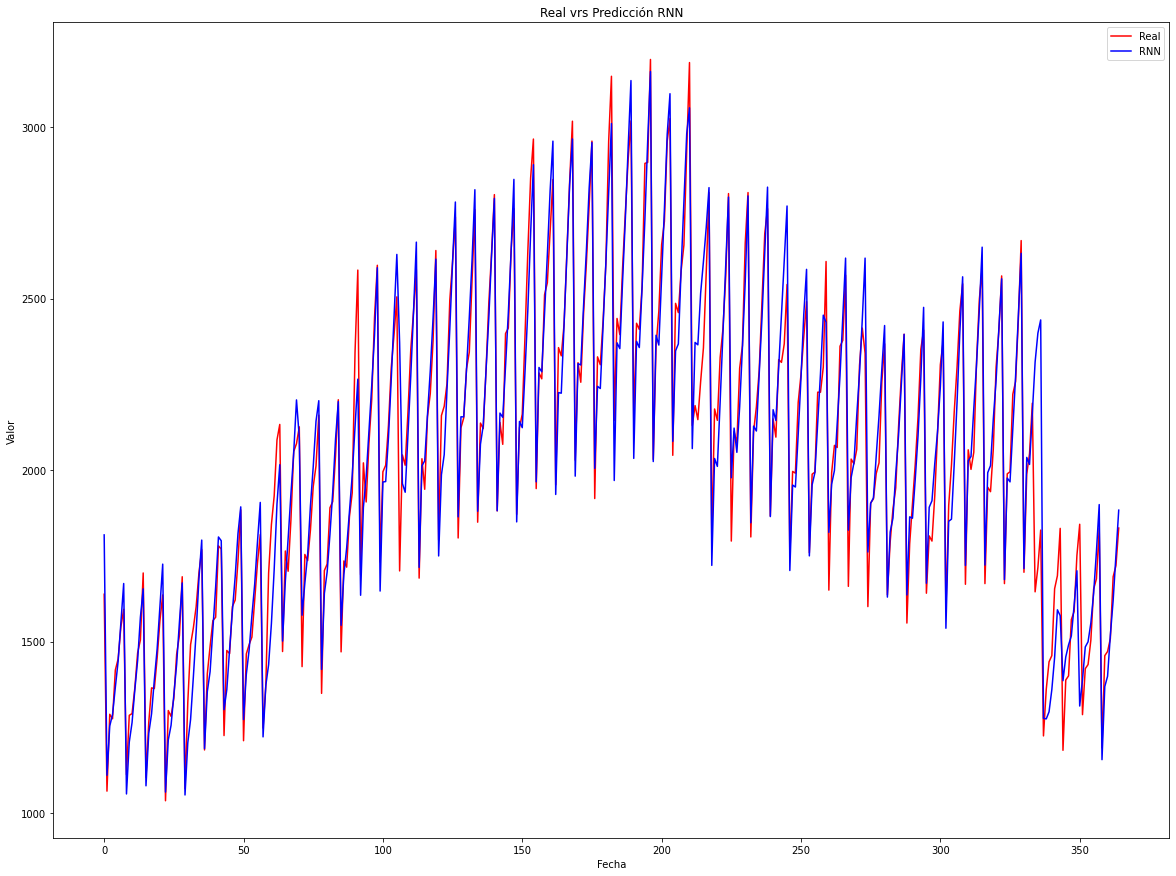

In [267]:
plt.figure(figsize=(20, 15))
plt.plot(real_test_price, color="red", label="Real")
plt.plot(real_predicted_price, color="blue", label="RNN")
plt.title("Real vrs Predicción RNN")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()

### Calculo SMAPE Tienda 7

In [268]:
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

In [269]:
smape(real_test_price, real_predicted_price)

3.732430434049885

### Tienda 8

In [336]:
datatrain8 = datatrain.query('store == 8')
datatrain8 = datatrain8.pivot(index = 'date', columns = 'item', values = 'sales')
datatrain8['Total_Sales'] = datatrain8.sum(axis = 1)
datatrain8 = datatrain8.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatrain8 = datatrain8.iloc[:, 0:1].values

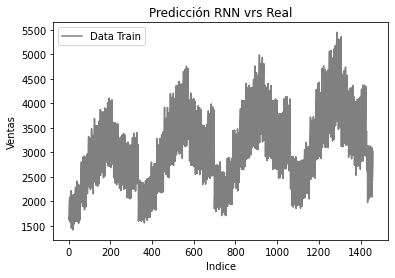

In [337]:
plt.plot(datatrain8, color='gray', label='Data Train')
plt.title('Predicción RNN vrs Real')
plt.xlabel("Indice")
plt.ylabel("Ventas")
plt.legend()
plt.show()

In [338]:
#from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
datatrain8_scaled = scaler.fit_transform(datatrain8)

In [339]:
X_train = []
Y_train = []

#secuenciamos los datos.
cantidad = datatrain8_scaled.shape[0]
ventana = 40
for i in range(ventana, cantidad):
  X_train.append(datatrain8_scaled[i - ventana: i, 0])
  Y_train.append(datatrain8_scaled[i, 0])

In [340]:
X_train = np.array(X_train)
y_train = np.array(Y_train)

In [341]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #reshape para entrada en Keras.

In [342]:
forecaster = Sequential()
#capa1
forecaster.add(LSTM(input_shape=(X_train.shape[1], 1), units=50, return_sequences=True))
#capa2
forecaster.add(LSTM(units=50, return_sequences=True))
#capa3
forecaster.add(LSTM(units=25, return_sequences=True))
#capa4 - NOTAAAAR :) que la capa previa a la salida, no requiere feedback ya que es el resultado final.
forecaster.add(LSTM(units=75, return_sequences=False))
#capa de salida
forecaster.add(Dense(units=1, activation='relu'))

In [343]:
#parametros de optimización
forecaster.compile(optimizer='adam', loss='mean_squared_error')

In [344]:
#parametros de entrenamiento
forecaster.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
45/45 [==============================] - 13s 82ms/step - loss: 0.0395
Epoch 2/100
45/45 [==============================] - 4s 82ms/step - loss: 0.0150
Epoch 3/100
45/45 [==============================] - 4s 82ms/step - loss: 0.0140
Epoch 4/100
45/45 [==============================] - 4s 82ms/step - loss: 0.0137
Epoch 5/100
45/45 [==============================] - 4s 83ms/step - loss: 0.0139
Epoch 6/100
45/45 [==============================] - 4s 83ms/step - loss: 0.0136
Epoch 7/100
45/45 [==============================] - 4s 82ms/step - loss: 0.0133
Epoch 8/100
45/45 [==============================] - 4s 83ms/step - loss: 0.0127
Epoch 9/100
45/45 [==============================] - 4s 83ms/step - loss: 0.0137
Epoch 10/100
45/45 [==============================] - 4s 84ms/step - loss: 0.0129
Epoch 11/100
45/45 [==============================] - 4s 84ms/step - loss: 0.0133
Epoch 12/100
45/45 [==============================] - 4s 84ms/step - loss: 0.0126
Epoch 13/100
45/45 [====

In [345]:
#forecaster.save('/content/drive/MyDrive/RNN_v1.h5')

In [346]:
datatest8 = datatest.query('store == 8')
datatest8 = datatest8.pivot(index = 'date', columns = 'item', values = 'sales')
datatest8['Total_Sales'] = datatest8.sum(axis = 1)
datatest8 = datatest8.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatest8 = datatest8.iloc[:, 0:1].values

In [347]:
real_test_price = datatest8

In [348]:
dataset_total = pd.concat((pd.Series(datatrain8[:,0]), pd.Series(datatest8[:,0])), axis=0)
#dataset_total

In [349]:
input_test = dataset_total[len(dataset_total) - len(datatest8) - ventana : ].values
input_test = input_test.reshape(-1, 1)
input_test = scaler.transform(input_test)
#input_test

In [350]:
cantidad_final = len(input_test)
cantidad_final

405

In [351]:
X_test = []
for i in range(ventana, cantidad_final):
  X_test.append(input_test[i - ventana:i, 0])

X_test = np.array(X_test)

In [352]:
X_test.shape

(365, 40)

In [353]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [354]:
X_test.shape

(365, 40, 1)

In [355]:
predicciones_rnn = forecaster.predict(X_test)
#predicciones_rnn

In [356]:
real_predicted_price = scaler.inverse_transform(predicciones_rnn)
#real_predicted_price

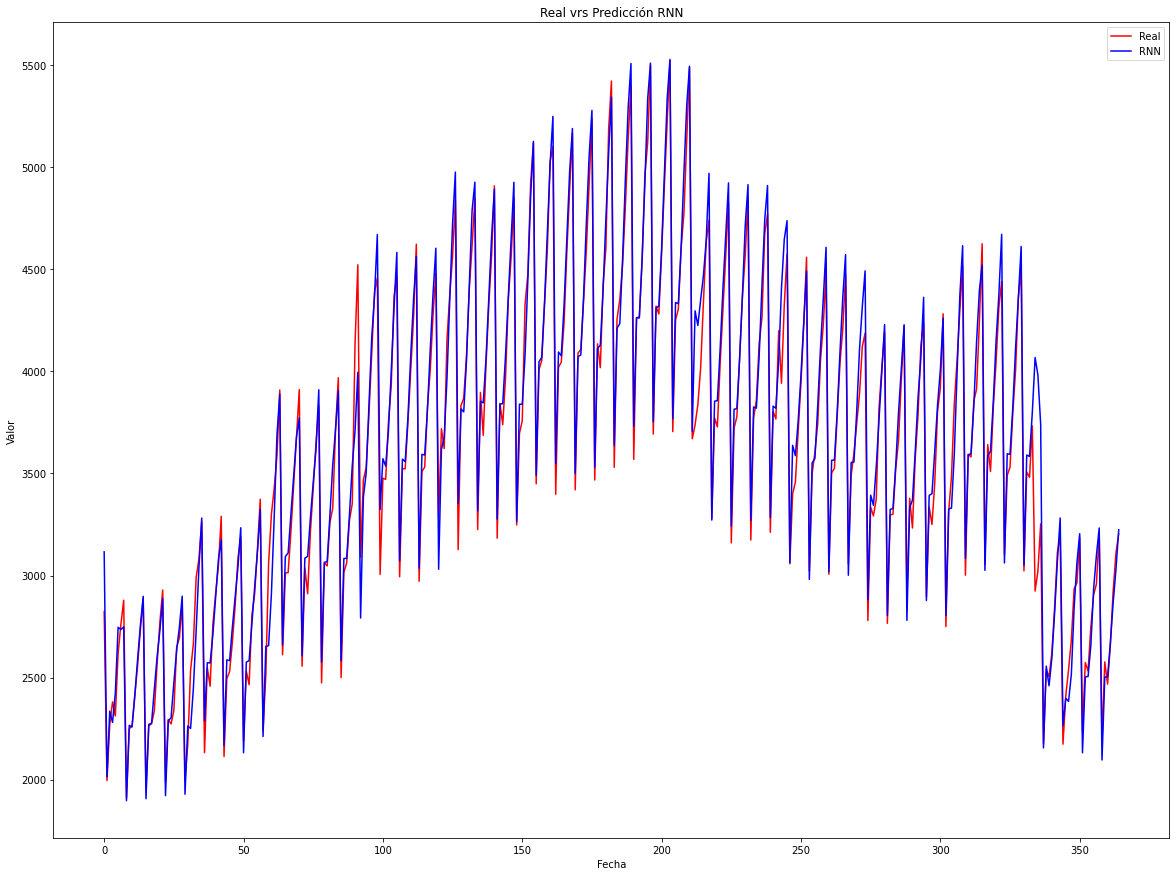

In [357]:
plt.figure(figsize=(20, 15))
plt.plot(real_test_price, color="red", label="Real")
plt.plot(real_predicted_price, color="blue", label="RNN")
plt.title("Real vrs Predicción RNN")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()

### Calculo SMAPE Tienda 8

In [358]:
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

In [359]:
smape(real_test_price, real_predicted_price)

2.5700402615431375

### Tienda 9

In [404]:
datatrain9 = datatrain.query('store == 9')
datatrain9 = datatrain9.pivot(index = 'date', columns = 'item', values = 'sales')
datatrain9['Total_Sales'] = datatrain9.sum(axis = 1)
datatrain9 = datatrain9.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatrain9 = datatrain9.iloc[:, 0:1].values

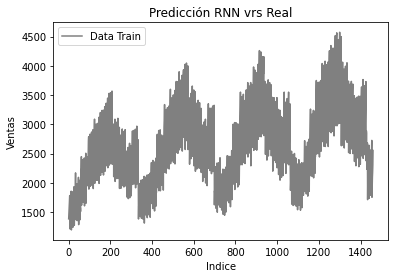

In [405]:
plt.plot(datatrain9, color='gray', label='Data Train')
plt.title('Predicción RNN vrs Real')
plt.xlabel("Indice")
plt.ylabel("Ventas")
plt.legend()
plt.show()

In [406]:
#from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
datatrain9_scaled = scaler.fit_transform(datatrain9)

In [407]:
X_train = []
Y_train = []

#secuenciamos los datos.
cantidad = datatrain9_scaled.shape[0]
ventana = 60
for i in range(ventana, cantidad):
  X_train.append(datatrain9_scaled[i - ventana: i, 0])
  Y_train.append(datatrain9_scaled[i, 0])

In [408]:
X_train = np.array(X_train)
y_train = np.array(Y_train)

In [409]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #reshape para entrada en Keras.

In [410]:
forecaster = Sequential()
#capa1
forecaster.add(LSTM(input_shape=(X_train.shape[1], 1), units=50, return_sequences=True))
#capa2
forecaster.add(LSTM(units=50, return_sequences=True))
#capa3
forecaster.add(LSTM(units=25, return_sequences=True))
#capa4 - NOTAAAAR :) que la capa previa a la salida, no requiere feedback ya que es el resultado final.
forecaster.add(LSTM(units=75, return_sequences=False))
#capa de salida
forecaster.add(Dense(units=1, activation='relu'))

In [411]:
#parametros de optimización
forecaster.compile(optimizer='adam', loss='mean_squared_error')

In [412]:
#parametros de entrenamiento
forecaster.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
44/44 [==============================] - 12s 119ms/step - loss: 0.0362
Epoch 2/100
44/44 [==============================] - 5s 118ms/step - loss: 0.0154
Epoch 3/100
44/44 [==============================] - 5s 119ms/step - loss: 0.0150
Epoch 4/100
44/44 [==============================] - 5s 119ms/step - loss: 0.0143
Epoch 5/100
44/44 [==============================] - 5s 118ms/step - loss: 0.0142
Epoch 6/100
44/44 [==============================] - 5s 119ms/step - loss: 0.0137
Epoch 7/100
44/44 [==============================] - 5s 118ms/step - loss: 0.0139
Epoch 8/100
44/44 [==============================] - 5s 118ms/step - loss: 0.0141
Epoch 9/100
44/44 [==============================] - 5s 119ms/step - loss: 0.0136
Epoch 10/100
44/44 [==============================] - 5s 118ms/step - loss: 0.0133
Epoch 11/100
44/44 [==============================] - 5s 119ms/step - loss: 0.0135
Epoch 12/100
44/44 [==============================] - 5s 119ms/step - loss: 0.0136
Epoch 13/100

In [413]:
#forecaster.save('/content/drive/MyDrive/RNN_v1.h5')

In [414]:
datatest9 = datatest.query('store == 9')
datatest9 = datatest9.pivot(index = 'date', columns = 'item', values = 'sales')
datatest9['Total_Sales'] = datatest9.sum(axis = 1)
datatest9 = datatest9.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatest9 = datatest9.iloc[:, 0:1].values

In [415]:
real_test_price = datatest9

In [416]:
dataset_total = pd.concat((pd.Series(datatrain9[:,0]), pd.Series(datatest9[:,0])), axis=0)
#dataset_total

In [417]:
input_test = dataset_total[len(dataset_total) - len(datatest9) - ventana : ].values
input_test = input_test.reshape(-1, 1)
input_test = scaler.transform(input_test)
#input_test

In [418]:
cantidad_final = len(input_test)
cantidad_final

425

In [419]:
X_test = []
for i in range(ventana, cantidad_final):
  X_test.append(input_test[i - ventana:i, 0])

X_test = np.array(X_test)

In [420]:
X_test.shape

(365, 60)

In [421]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [422]:
X_test.shape

(365, 60, 1)

In [423]:
predicciones_rnn = forecaster.predict(X_test)
#predicciones_rnn

In [424]:
real_predicted_price = scaler.inverse_transform(predicciones_rnn)
#real_predicted_price

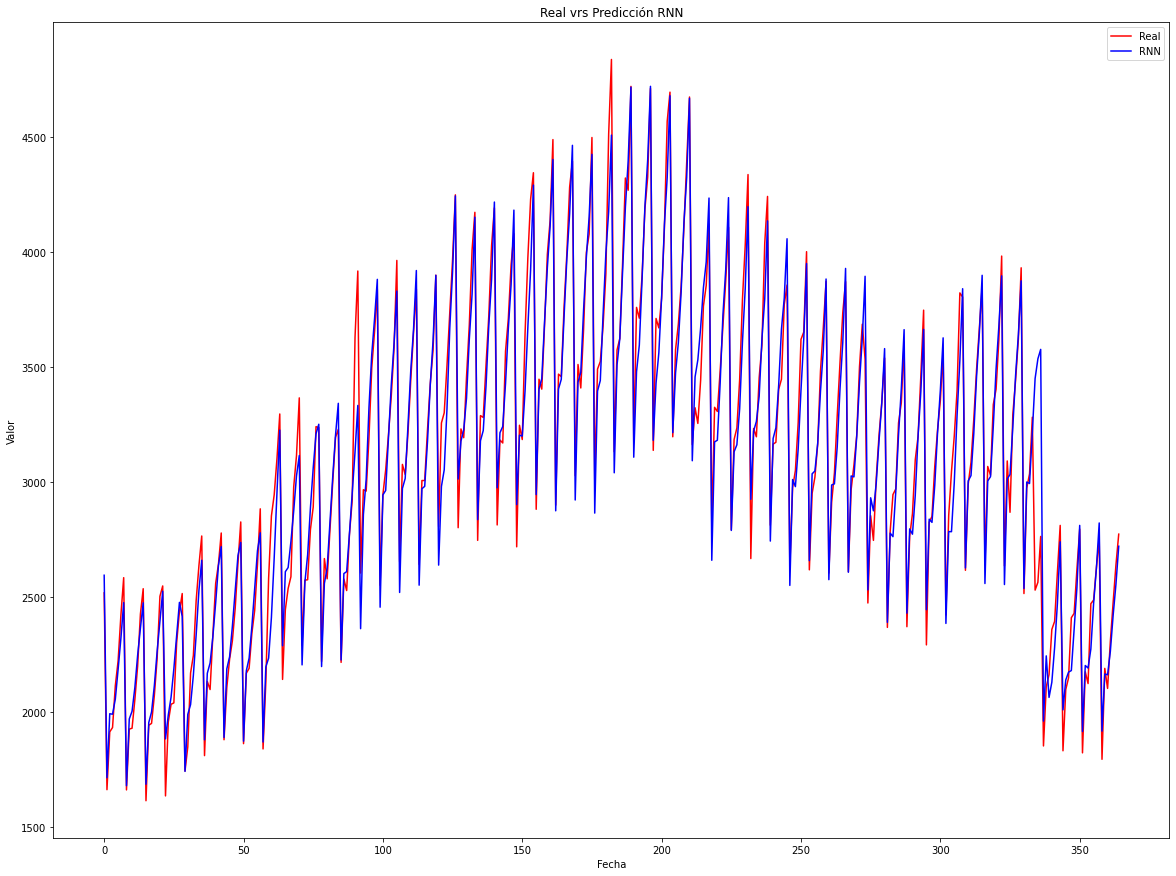

In [425]:
plt.figure(figsize=(20, 15))
plt.plot(real_test_price, color="red", label="Real")
plt.plot(real_predicted_price, color="blue", label="RNN")
plt.title("Real vrs Predicción RNN")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()

### Calculo SMAPE Tienda 9

In [426]:
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

In [427]:
smape(real_test_price, real_predicted_price)

3.0681707542166015

### Tienda 10

In [450]:
datatrain10 = datatrain.query('store == 10')
datatrain10 = datatrain10.pivot(index = 'date', columns = 'item', values = 'sales')
datatrain10['Total_Sales'] = datatrain10.sum(axis = 1)
datatrain10 = datatrain10.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatrain10 = datatrain10.iloc[:, 0:1].values

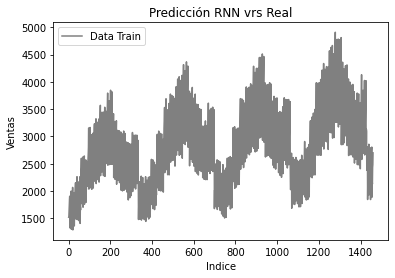

In [451]:
plt.plot(datatrain10, color='gray', label='Data Train')
plt.title('Predicción RNN vrs Real')
plt.xlabel("Indice")
plt.ylabel("Ventas")
plt.legend()
plt.show()

In [452]:
#from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
datatrain10_scaled = scaler.fit_transform(datatrain10)

In [453]:
X_train = []
Y_train = []

#secuenciamos los datos.
cantidad = datatrain10_scaled.shape[0]
ventana = 20
for i in range(ventana, cantidad):
  X_train.append(datatrain10_scaled[i - ventana: i, 0])
  Y_train.append(datatrain10_scaled[i, 0])

In [454]:
X_train = np.array(X_train)
y_train = np.array(Y_train)

In [455]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #reshape para entrada en Keras.

In [456]:
forecaster = Sequential()
#capa1
forecaster.add(LSTM(input_shape=(X_train.shape[1], 1), units=50, return_sequences=True))
#capa2
forecaster.add(LSTM(units=50, return_sequences=True))
#capa3
forecaster.add(LSTM(units=25, return_sequences=True))
#capa4 - NOTAAAAR :) que la capa previa a la salida, no requiere feedback ya que es el resultado final.
forecaster.add(LSTM(units=75, return_sequences=False))
#capa de salida
forecaster.add(Dense(units=1, activation='relu'))

In [457]:
#parametros de optimización
forecaster.compile(optimizer='adam', loss='mean_squared_error')

In [458]:
#parametros de entrenamiento
forecaster.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
46/46 [==============================] - 9s 42ms/step - loss: 0.0345
Epoch 2/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0148
Epoch 3/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0153
Epoch 4/100
46/46 [==============================] - 2s 43ms/step - loss: 0.0150
Epoch 5/100
46/46 [==============================] - 2s 44ms/step - loss: 0.0139
Epoch 6/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0138
Epoch 7/100
46/46 [==============================] - 2s 43ms/step - loss: 0.0133
Epoch 8/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0129
Epoch 9/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0134
Epoch 10/100
46/46 [==============================] - 2s 43ms/step - loss: 0.0157
Epoch 11/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0143
Epoch 12/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0139
Epoch 13/100
46/46 [=====

In [459]:
#forecaster.save('/content/drive/MyDrive/RNN_v1.h5')

In [460]:
datatest10 = datatest.query('store == 10')
datatest10 = datatest10.pivot(index = 'date', columns = 'item', values = 'sales')
datatest10['Total_Sales'] = datatest10.sum(axis = 1)
datatest10 = datatest10.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatest10 = datatest10.iloc[:, 0:1].values

In [461]:
real_test_price = datatest10

In [462]:
dataset_total = pd.concat((pd.Series(datatrain10[:,0]), pd.Series(datatest10[:,0])), axis=0)
#dataset_total

In [463]:
input_test = dataset_total[len(dataset_total) - len(datatest10) - ventana : ].values
input_test = input_test.reshape(-1, 1)
input_test = scaler.transform(input_test)
#input_test

In [464]:
cantidad_final = len(input_test)
cantidad_final

385

In [465]:
X_test = []
for i in range(ventana, cantidad_final):
  X_test.append(input_test[i - ventana:i, 0])

X_test = np.array(X_test)

In [466]:
X_test.shape

(365, 20)

In [467]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [468]:
X_test.shape

(365, 20, 1)

In [469]:
predicciones_rnn = forecaster.predict(X_test)
#predicciones_rnn

In [470]:
real_predicted_price = scaler.inverse_transform(predicciones_rnn)
#real_predicted_price

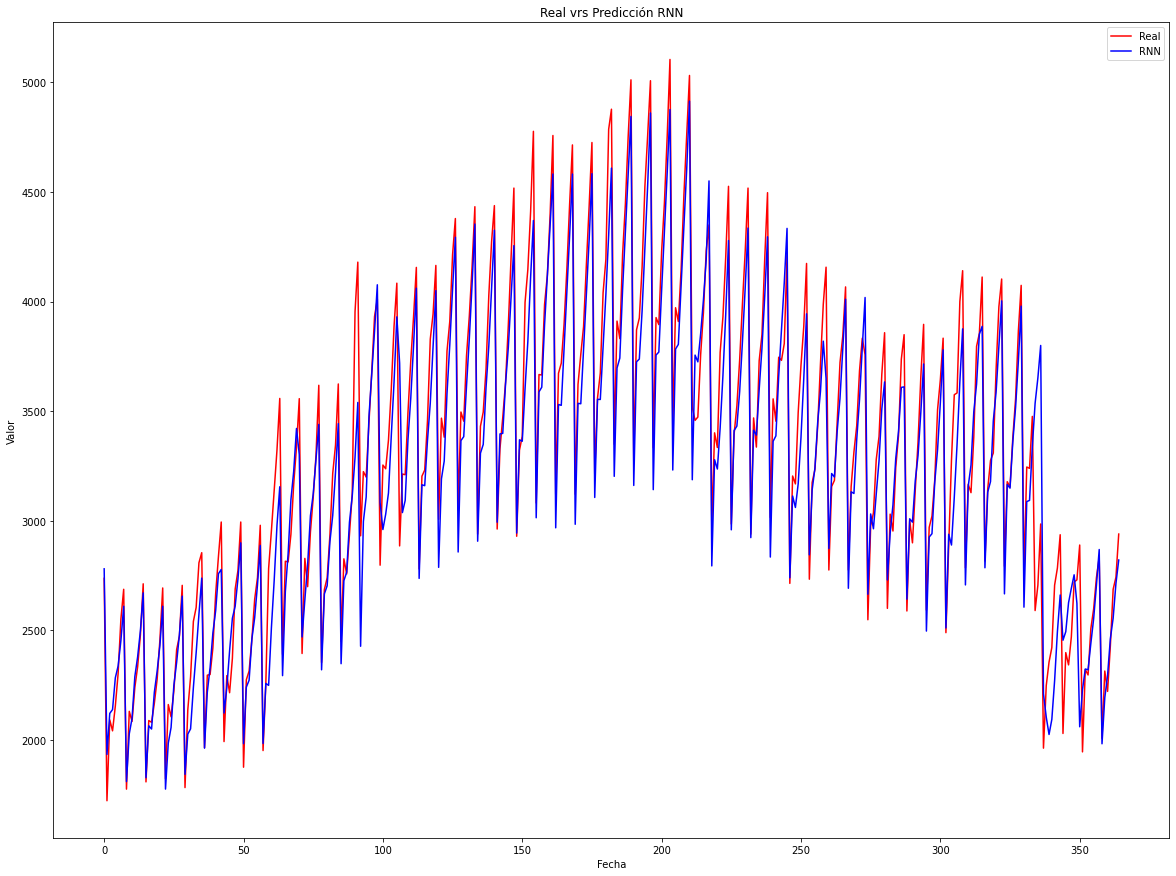

In [471]:
plt.figure(figsize=(20, 15))
plt.plot(real_test_price, color="red", label="Real")
plt.plot(real_predicted_price, color="blue", label="RNN")
plt.title("Real vrs Predicción RNN")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()

### Calculo SMAPE Tienda 10

In [472]:
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

In [473]:
smape(real_test_price, real_predicted_price)

4.506619854594505